In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from matplotlib.patches import Ellipse
%matplotlib inline
import math
import fitClus2D as fc
from scipy.stats import sigmaclip
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

import astropy
from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.wcs import WCS
from astropy.cosmology import LambdaCDM

from PIL import Image

# These cuts get you a 4x4 arcmin square centered on the image center of the fields
img_cuts = {'a2744':[[519,4520],[412,4413]],
            'm0416':[[367,4368],[380,4381]]}
img_files = {'a2744':'Files/abell2744_RGB.fits',
             'm0416':'Files/macs0416_RGB.fits'}

zclus = {'a2744' : 0.308,
         'm0416' : 0.396}
pgals = {'a2744' : [1.689791e-01, 1.965115e+00, 2.0],
        'm0416' : [3.737113e-01, 1.322081e+00, 2.0]}


In [3]:
cluster = 'a2744'
catalog = "Files/" + cluster + "_master_cleaned.csv"

#Set up clusters, not clusters, and unknowns
dzcut=0.03; sigclip=3; sigcut=3; radialcut=120; maglim=23.5; colorcut=1.0
master = pd.read_csv(catalog)
zdat = master['master_z']
valid = master['master_valid']
memberindx = np.where((zdat>zclus[cluster]-dzcut)&(zdat<zclus[cluster]+dzcut)&(valid==1))[0]
z1 = zdat[memberindx]
z2 = sigma_clip(z1,sigma=sigclip)
print(np.mean(z2),np.std(z2))

dz = sigcut*np.std(z2)
print(dz)
ddat = master['master_d']
zdat = master['master_z']
mag814 = master['master_mag814']
mag606 = master['master_mag606']
valid = master['master_valid']
master_cut = master.iloc[np.where((ddat<radialcut)&(~np.isnan(mag606))&(~np.isnan(mag814))&(mag814<=maglim)&(valid == 1))]

zdat   = master_cut['master_z']
nmemindx = np.where((zdat<zclus[cluster]-dz)|(zdat>zclus[cluster]+dz))[0]
memindx = np.where((zdat>zclus[cluster]-dz)&(zdat<zclus[cluster]+dz))[0]
unknownindx = np.where(np.isnan(zdat))[0]

clusterarr = [master_cut.iloc[i] for i in memindx]
ncluster =[master_cut.iloc[i] for i in nmemindx]
unknown = [master_cut.iloc[i] for i in unknownindx]

XclustCM= [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in clusterarr]
XnclustCM = [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in ncluster]
Xcm = np.array(XclustCM + XnclustCM)

Xclustall= [[row['master_mag814'], row['master_mag606'] - row['master_mag814'], row['master_d']] for row in clusterarr]
Xnclustall = [[row['master_mag814'], row['master_mag606'] - row['master_mag814'], row['master_d']] for row in ncluster]
Xall = np.array(Xclustall + Xnclustall)

unknownXcm = [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in unknown]
unknownXcm = np.array(unknownXcm)

y = np.zeros(len(clusterarr) + len(ncluster))
y[:len(clusterarr)] = 1

clustnum = len(clusterarr)
nclustnum = len(ncluster)
print(len(memindx))
print(len(nmemindx))
print(len(unknownindx))


0.3069860850098326 0.007357462290748165
0.022072386872244495
92
46
235


In [4]:
# Read in RGB file 
RGB = fits.open(img_files[cluster])

# Put separate extensions into own R/G/B arrays
imr=Image.fromarray(RGB[1].data,mode=None) 
img=Image.fromarray(RGB[2].data,mode=None)
imb=Image.fromarray(RGB[3].data,mode=None)

# Merge them back into one image
merged=Image.merge("RGB",(imr,img,imb))

# Conversion factor to translate between x & y and pixels
# In units of arcseconds per pixel
conv = 23.8809/398.015 

# Cut image down to square shape & zoom in since it's a little big
xx = img_cuts[cluster][0] # sets area to cut to
yy = img_cuts[cluster][1]
val = 0 # sets zoom in

imgcut = np.array(merged)[xx[0]+val:xx[1]-val,yy[0]+val:yy[1]-val]

In [5]:
#Set up images
cosmo = LambdaCDM(H0 = 70, Om0 = 0.3, Ode0 = 0.7)
img = fc.imgclass("Files/" + cluster + "_images.dat", zclus[cluster], cosmo)

Read image data from file Files/a2744_images.dat


In [6]:
#Ways to assign probabilities
def normalize(X, p):
    copyX = np.copy(X)
    copyp = np.copy(p)
    for i in range((len(X[0]))):
        mn = np.min(X[:,i])
        mx = np.max(X[:,i])
        copyX[:,i] = (X[:,i] - mn) / (mx - mn)
        copyp[:,i] = (p[:,i] - mn) / (mx - mn)
    
    return copyX, copyp
    
def Knn(X, y, p, k):
    normX, normp = normalize(X, p)
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(normX, y)
    return model.predict_proba(normp)[:,1], model.predict(normp)

def Rnn(X, y, p, r):
    normX, normp = normalize(X, p)
    model = RadiusNeighborsClassifier(radius = r, outlier_label = 0)
    model.fit(normX, y)
    return model.predict_proba(normp)[:,1], model.predict(normp)

def box(X, y, p, numx, numy):
    minm = np.min(Xcm[:,0])
    maxm = np.max(Xcm[:,0])
    minc = np.min(Xcm[:,1])
    maxc = np.max(Xcm[:,1])
    w = maxm - minm
    h = maxc - minc
    minm -= 0.01 * w
    maxm += 0.01 * w
    minc -= 0.01 * h
    maxc += 0.01 * h
    
    boxw = (maxm - minm) / numx
    boxh = (maxc - minc) / numy
    grid = np.zeros((numx, numy, 2))
    
    for i, point in enumerate(X):
        xcoor = int((point[0] - minm) / boxw)
        ycoor = int((point[1] - minc) / boxh)
        grid[xcoor, ycoor, 1] += 1
        grid[xcoor, ycoor, 0] += y[i]
        
    probs = np.zeros(len(p))
    classes = np.zeros(len(p))
    
    for i, point in enumerate(p):
        if point[0] >= minm and point[0] < maxm and point[1] >= minc and point[1] <= maxc:
            xcoor = int((point[0] - minm) / boxw)
            ycoor = int((point[1] - minc) / boxh)
            if not grid[xcoor, ycoor, 1] == 0:
                probs[i] = grid[xcoor, ycoor, 0] / grid[xcoor, ycoor, 1]
                if probs[i] > 0.5: classes[i] = 1
                    
    return probs, classes

def sigmaCut(X, y, p, k):
    clustermag = [dat[0] for i, dat in enumerate(X) if y[i] == 1]
    clustercolor = [dat[1] for i, dat in enumerate(X) if y[i] == 1]
    
    model = np.polyfit(clustermag, clustercolor, 1)
    predict = np.poly1d(model)
    
    res = clustercolor - predict(clustermag)
    sigma = np.std(res)
    
    probs = np.zeros(len(p))
    classes = np.zeros(len(p))
    
    nclust = 0
    ntot = 0
    
    for i, point in enumerate(X):
        if abs(point[1] - predict(point[0])) < k * sigma:
            if y[i] == 1:
                nclust += 1
            ntot += 1
    prob = nclust / ntot
    
    for i, point in enumerate(p):
        if abs(point[1] - predict(point[0])) < k * sigma:
               probs[i] = prob
               classes[i] = 1
    return probs, classes


In [7]:
clusterData = [[row['master_x'], row['master_y'], row['master_mag814'], 1] for row in clusterarr]
unknownData = [[row['master_x'], row['master_y'], row['master_mag814'], 0] for row in unknown]
data = np.array(clusterData + unknownData)


    
#draw scatter plot of uncertainties in varying cluster members, or in scattering
def scatterDraw(n, scatter, ax, probs = [], color = "red"):
    global data
    colors = ["red", "blue", "green"]
    data[clustnum:,3] = probs
    
    gal = fc.galclass(data)
    gal.scale()
    alldeflect = []
    
    for i in range(n):
        gal.draw(scatter)
        deflect, gamma = gal.calcdefbasic(images)
        alldeflect.append(deflect)

    alldeflect = np.array(alldeflect)
    for i in range(len(images)):
        x = alldeflect[:,i,0]
        y = alldeflect[:,i,1]
        ax.scatter(x, y, color = color, alpha = 0.5)
    
    return np.mean(alldeflect, axis = 0)


In [8]:
#Get probability arrays
knnprob = Knn(Xcm, y, unknownXcm, 12)[0]
rnnprob = Rnn(Xcm, y, unknownXcm, 0.25)[0]
boxprob = box(Xcm, y, unknownXcm, 3, 5)[0]
sigmaclass = sigmaCut(Xcm, y, unknownXcm, 1.0)[1]

Read in 327 galaxies
Read in 327 galaxies
Read in 327 galaxies
Read in 327 galaxies
Read in 327 galaxies
Read in 327 galaxies


Text(0.5, 1.0, 'Boxes')

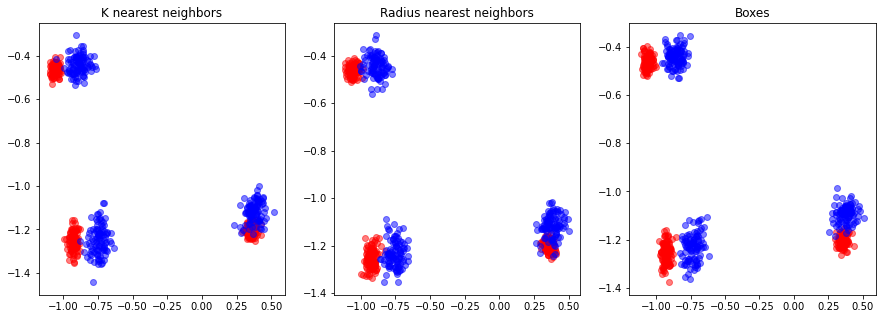

In [9]:
images = np.array([[-28.5912, -24.0012], [-23.6743, -34.4608], [6.5976, -45.8501]])
fig,((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,5))

scatterDraw(100, True, ax1, sigmaclass)
scatterDraw(100, True, ax2, sigmaclass)
scatterDraw(100, True, ax3, sigmaclass)

scatterDraw(100, True, ax1, knnprob, "blue")
scatterDraw(100, True, ax2, rnnprob, "blue")
scatterDraw(100, True, ax3, boxprob, "blue")
ax1.set_title("K nearest neighbors")
ax2.set_title("Radius nearest neighbors")
ax3.set_title("Boxes")

In [16]:
def getStats(n, probs, scatter, img = img):
    global data
    data[clustnum:,3] = probs

    gal = fc.galclass(data)
    gal.scale()

    deflects = fc.defclass()
    deflects.draw(gal, img, 1.0, [1.9, 1.965115, 2.1], n, scatter = scatter, basename = 'Files/Abell_member-def',
                  useD = True)
    return deflects.marr, deflects.Garr, deflects.Cmat

def scatterMeans(n, probs, scatter, ax, color):
    marr = getStats(n, probs, scatter)[0]
    ax.scatter(marr[0,:,0], marr[0,:,1], color = color)
    return marr


In [17]:
ret = getStats(100, rnnprob, True)
print(ret[0].shape)

Read in 327 galaxies
Generating deflection distribution: a = 1.9
Step 0
Generating deflection distribution: a = 1.965115
Step 0
Generating deflection distribution: a = 2.1
Step 0
Writing to files with basename Files/Abell_member-def
(3, 71, 2)
